In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
def add_won_next_game(group):
    group["Won Next"] = group["won"].shift(-1)
    return group

df = pd.read_csv("nba_games.csv", index_col=0)
df = df.sort_values("date").reset_index(drop=True).drop(['mp', 'mp.1', 'index_opp'], axis = 1)
df = df.groupby("team", group_keys=False).apply(add_won_next_game).dropna(subset=["Won Next"])
df[df['team'] == 'OKC']

fg    fga    fg%    3p   3pa    3p%    ft   fta    ft%   orb  ...  \
20     42.0   86.0  0.488   7.0  19.0  0.368  21.0  22.0  0.955  11.0  ...   
55     50.0  110.0  0.455   8.0  27.0  0.296  31.0  38.0  0.816  22.0  ...   
87     45.0   86.0  0.523  13.0  25.0  0.520  14.0  18.0  0.778  13.0  ...   
97     40.0   84.0  0.476  10.0  23.0  0.435  15.0  22.0  0.682  14.0  ...   
121    39.0   82.0  0.476   8.0  23.0  0.348  12.0  14.0  0.857  11.0  ...   
...     ...    ...    ...   ...   ...    ...   ...   ...    ...   ...  ...   
17442  36.0   84.0  0.429  11.0  34.0  0.324  18.0  29.0  0.621  12.0  ...   
17475  43.0   87.0  0.494  17.0  41.0  0.415  14.0  18.0  0.778  12.0  ...   
17487  39.0   81.0  0.481   9.0  29.0  0.310  11.0  22.0  0.500  13.0  ...   
17509  37.0   90.0  0.411  16.0  37.0  0.432  11.0  17.0  0.647  11.0  ...   
17539  40.0   88.0  0.455   6.0  29.0  0.207  15.0  19.0  0.789   9.0  ...   

       usg%_max_opp  ortg_max_opp  drtg_max_opp  team_opp  total_opp  \
20             33.1         159.0         119.0       SAS        106   
55             27.1         173.0         126.0       ORL        136   
87             28.4         226.0         131.0       DEN         93   
97             36.0         115.0         110.0       HOU        110   
121            30.0         156.0         110.0       TOR        103   
...             ...           ...           ...       ...        ...   
17442          34.0         211.0         114.0       DET        110   
17475          31.6         250.0         133.0       PHO         96   
17487          30.6         218.0         115.0       POR         94   
17509          32.9         216.0         121.0       UTA        137   
17539          28.0         214.0         106.0       LAL        120   

       home_opp  season        date    won  Won Next  
20            0    2016  2015-10-28   True      True  
55            1    2016  2015-10-30   True      True  
87            0    2016  2015-11-01   True     False  
97            1    2016  2015-11-02  False     False  
121           0    2016  2015-11-04  False     False  
...         ...     ...         ...    ...       ...  
17442         0    2022  2022-04-01  False      True  
17475         0    2022  2022-04-03   True      True  
17487         0    2022  2022-04-05   True     False  
17509         1    2022  2022-04-06  False     False  
17539         1    2022  2022-04-08  False     False  

[594 rows x 148 columns]

In [3]:
#remove null columns
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > (len(df) * .9)]
valid_columns = df.columns[~df.columns.isin(nulls.index)]
df = df[valid_columns]

#remove date
df = df.drop(columns=['date'])

#remove no variance columns
numerical_data = df.select_dtypes(include=['float64', 'int64'])
selector = VarianceThreshold(threshold= 0.01)
filtered_data_low_variance = selector.fit_transform(numerical_data)
retained_columns_variance = numerical_data.columns[selector.get_support()]

#remove features with high multicolliniarity
correlation_matrix_reduced = pd.DataFrame(filtered_data_low_variance, columns=retained_columns_variance).corr()

threshold = 0.9 
to_drop = set()
for i in range(correlation_matrix_reduced.shape[0]):
    for j in range(i + 1, correlation_matrix_reduced.shape[1]):
        if abs(correlation_matrix_reduced.iloc[i, j]) > threshold:
            to_drop.add(correlation_matrix_reduced.columns[j])

final_numerical_columns = [col for col in retained_columns_variance if col not in to_drop]

In [4]:
non_numeric_columns = df.select_dtypes(exclude=['number'])
df = pd.concat([non_numeric_columns, df[final_numerical_columns]], axis=1)

season_column = df['season']
df = df.drop('season', axis = 1)

scaler = StandardScaler()
final_numerical_columns.remove('season')

df[final_numerical_columns] = scaler.fit_transform(df[final_numerical_columns])
df['season'] = season_column

df = pd.get_dummies(df, columns= ['team', 'team_opp', 'won'], drop_first=True)
df

Won Next        fg       fga        3p       3pa        ft       ft%  \
0        False -0.948757 -0.555662 -1.267673 -1.618856  0.265002 -0.646104   
1         True -0.374773  0.964717 -0.510263 -0.226759 -1.243176 -1.773112   
2         True -0.566101 -0.002797 -1.015203 -1.492301 -0.237724 -0.723828   
3         True  0.199211  1.241149 -0.510263 -0.100205  0.432577  1.345592   
4         True -0.566101 -0.693878 -0.762733 -0.479868 -0.908026  0.286593   
...        ...       ...       ...       ...       ...       ...       ...   
17765    False  0.581867  0.273636  0.499619  0.532566 -0.070149 -0.607241   
17766     True  0.007883  0.550068  1.004559  1.545000 -0.908026  0.286593   
17767    False -1.140085 -0.279229  1.004559  0.912229 -0.572875 -0.325489   
17768     True  0.199211  0.135419 -0.510263  1.165338 -0.740450  0.937537   
17769    False -1.714070 -1.661391 -0.005322  0.152904  0.600152 -0.908425   

            orb       drb       trb  ...  team_opp_ORL  team_opp_PHI  \
0     -0.563913 -1.671141 -1.700801  ...         False         False   
1      0.242071  0.917663  0.895528  ...         False         False   
2     -0.832574  1.102577  0.437353  ...         False         False   
3      2.928682  0.178004  1.811880  ...         False         False   
4     -0.832574 -0.191825 -0.631724  ...         False         False   
...         ...       ...       ...  ...           ...           ...   
17765  1.316715 -0.376739  0.437353  ...         False         False   
17766  1.585376  0.917663  1.659155  ...         False         False   
17767  0.242071 -0.561654 -0.326274  ...         False         False   
17768 -1.638557  0.178004 -0.784449  ...         False         False   
17769 -0.563913  0.917663  0.437353  ...         False         False   

       team_opp_PHO  team_opp_POR  team_opp_SAC  team_opp_SAS  team_opp_TOR  \
0             False         False         False         False         False   
1             False         False         False         False         False   
2             False         False         False         False         False   
3             False         False         False         False         False   
4             False         False         False         False         False   
...             ...           ...           ...           ...           ...   
17765         False         False         False         False         False   
17766         False         False         False         False         False   
17767         False         False         False         False         False   
17768         False         False         False         False         False   
17769         False         False         False         False         False   

       team_opp_UTA  team_opp_WAS  won_True  
0             False         False     False  
1             False         False     False  
2             False         False      True  
3             False         False      True  
4             False         False     False  
...             ...           ...       ...  
17765         False         False      True  
17766         False         False      True  
17767         False         False     False  
17768         False         False      True  
17769         False         False     False  

[17742 rows x 156 columns]

In [5]:
train_seasons = [2016, 2017, 2018, 2019, 2020, 2021]  
test_seasons = [2022]

# Create training set
X = df.drop(columns=['Won Next']) 
y = df['Won Next'] 
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train = X[df['season'].isin(train_seasons)]
y_train = y[df['season'].isin(train_seasons)]

# Create testing set
X_test = X[df['season'].isin(test_seasons)]
y_test = y[df['season'].isin(test_seasons)]

X_train = X_train.drop('season', axis=1)
X_test = X_test.drop('season', axis=1)

In [6]:
gbr = GradientBoostingClassifier(n_estimators=200, max_leaf_nodes= 100, random_state = 2024)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

model_2f_acc = accuracy_score(y_test, gbr_preds)
print(f'GBC Test Accuracy: {model_2f_acc:.4f}')

GBC Test Accuracy: 0.5505


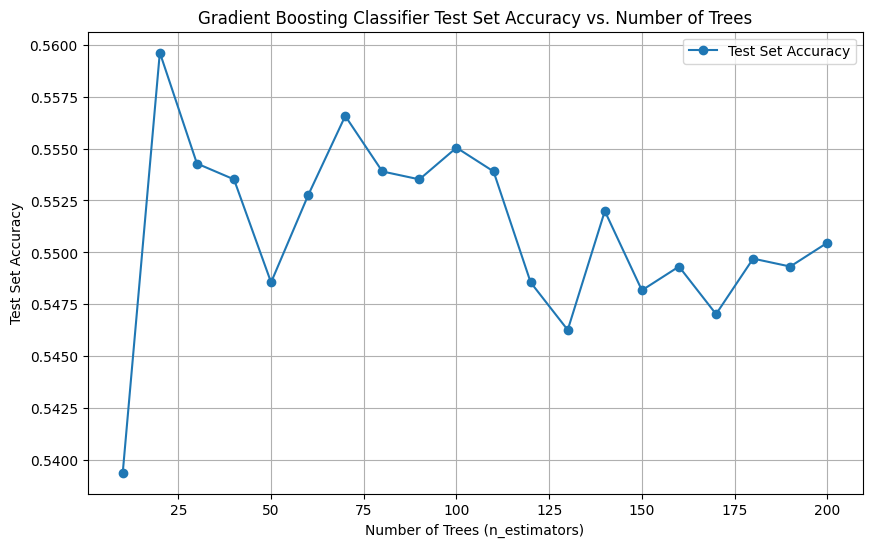

In [7]:
test_accuracies = []

n_estimators_range = range(10, 201, 10)
for n in n_estimators_range:
    # Initialize the Gradient Boosting Classifier with the current number of estimators
    gbr = GradientBoostingClassifier(n_estimators=n, max_leaf_nodes=100, random_state=2024)
    gbr.fit(X_train, y_train)
    
    gbr_preds = gbr.predict(X_test)
    test_acc = accuracy_score(y_test, gbr_preds)
    test_accuracies.append(test_acc)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, test_accuracies, marker='o', linestyle='-', label='Test Set Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Test Set Accuracy')
plt.title('Gradient Boosting Classifier Test Set Accuracy vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
gbr = GradientBoostingClassifier(n_estimators=20, max_leaf_nodes= 100, random_state = 2024)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

model_2f_acc = accuracy_score(y_test, gbr_preds)
print(f'GBC Test Accuracy: {model_2f_acc:.4f}')

GBC Test Accuracy: 0.5596


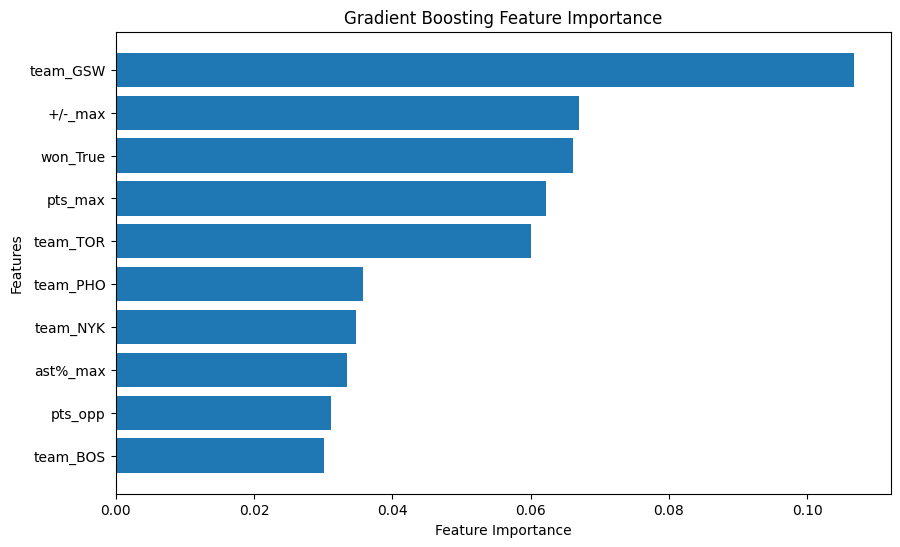

In [9]:
feature_importances = gbr.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.show()

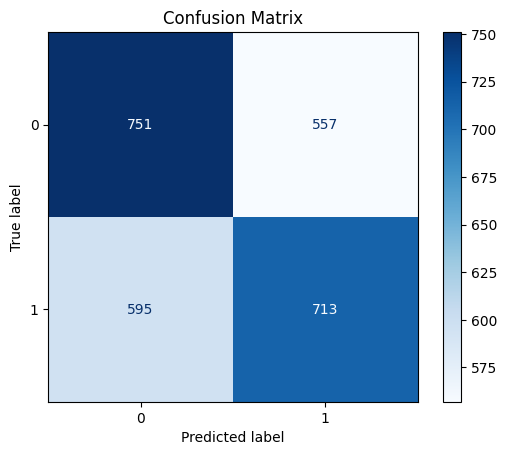

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(gbr, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, gbr.predict(X_test))
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
TPR = TP / (TP + FN)  # Sensitivity, Recall
FPR = FP / (FP + TN)
Precision = TP / (TP + FP)

# Print metrics
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"Precision: {Precision:.2f}")

True Positive Rate (TPR): 0.55
False Positive Rate (FPR): 0.43
Precision: 0.56


In [12]:
data = {
    "Model": ["Baseline", "Random Forest", "Logistic Regression", "XGBoost"],
    "Accuracy": [0.51, 0.5321, 0.5428, 0.5596],  # Replace with actual accuracy values
    "TPR (Recall)": [0.93, 0.57, 0.60, 0.55],  # Replace with actual TPR values
    "FPR": [0.91, 0.51, 0.51, 0.43],  # Replace with actual FPR values
    "Precision": [0.51, 0.53, 0.54, 0.56]  # Replace with actual precision values
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Display the table
print(results_df)

                 Model  Accuracy  TPR (Recall)   FPR  Precision
0             Baseline    0.5100          0.93  0.91       0.51
1        Random Forest    0.5321          0.57  0.51       0.53
2  Logistic Regression    0.5428          0.60  0.51       0.54
3              XGBoost    0.5596          0.55  0.43       0.56
